In [1]:
"""
Reusable KDE Analysis Script for Model Preprocessing Comparison
================================================================
Compares model-agnostic vs model-specific preprocessing performance
with comprehensive statistical analysis and data leakage detection.

Usage:
------
# Set your parameters
model_agnostic_path = '/path/to/model_agnostic.csv'
model_specific_path = '/path/to/model_specific.csv'
output_dir = '/path/to/output/figures'

# Run the analysis
analyzer = PreprocessingComparison(
    model_agnostic_path=model_agnostic_path,
    model_specific_path=model_specific_path,
    output_dir=output_dir,
    val_col='val_mean',  # column name for validation performance
    test_col='mean'      # column name for test performance
)

analyzer.run_full_analysis()
"""

"\nReusable KDE Analysis Script for Model Preprocessing Comparison\n================================================================\nCompares model-agnostic vs model-specific preprocessing performance\nwith comprehensive statistical analysis and data leakage detection.\n\nUsage:\n------\n# Set your parameters\nmodel_agnostic_path = '/path/to/model_agnostic.csv'\nmodel_specific_path = '/path/to/model_specific.csv'\noutput_dir = '/path/to/output/figures'\n\n# Run the analysis\nanalyzer = PreprocessingComparison(\n    model_agnostic_path=model_agnostic_path,\n    model_specific_path=model_specific_path,\n    output_dir=output_dir,\n    val_col='val_mean',  # column name for validation performance\n    test_col='mean'      # column name for test performance\n)\n\nanalyzer.run_full_analysis()\n"

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os


from pathlib import Path
from datetime import datetime
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [3]:
class PreprocessingComparison:
    """
    Compare model-agnostic vs model-specific preprocessing approaches.
    
    Parameters:
    -----------
    model_agnostic_path : str
        Path to CSV file with model-agnostic results
    model_specific_path : str
        Path to CSV file with model-specific results
    output_dir : str
        Directory to save output figures
    val_col : str
        Column name for validation performance (default: 'val_mean')
    test_col : str
        Column name for test performance (default: 'mean')
    metric_name : str
        Name of the performance metric (default: 'Log Loss')
    lower_is_better : bool
        Whether lower values are better (default: True for log loss)
    """
    
    def __init__(self, model_agnostic_path, model_specific_path, output_dir, title,
                 filename, val_col='val_mean', test_col='mean', metric_name='Log Loss',
                 lower_is_better=True):
        
        self.model_agnostic_path = model_agnostic_path
        self.model_specific_path = model_specific_path
        self.output_dir = Path(output_dir)
        self.title = title
        self.val_col = val_col
        self.test_col = test_col
        self.metric_name = metric_name
        self.lower_is_better = lower_is_better
        self.filename =filename
        
        # Create output directory if it doesn't exist
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        # Load data
        self._load_data()
        
        # Colors and styles
        self.colors = {
            'MAP val': '#1f77b4',
            'MAP test': '#ff7f0e',
            'MSP val': '#2ca02c',
            'MSP test': '#d62728'
        }
        
        self.line_styles = {
            'MAP val': '-',
            'MAP test': '--',
            'MSP val': '-',
            'MSP test': '--'
        }
    
    def _load_data(self):
        """Load and validate data from CSV files."""
        print("="*80)
        print("                    LOADING DATA")
        print("="*80)
        
        # Load CSVs
        self.ma_df = pd.read_csv(self.model_agnostic_path)
        self.ms_df = pd.read_csv(self.model_specific_path)
        
        # Extract distributions
        self.ma_val = self.ma_df[self.val_col].dropna()
        self.ma_test = self.ma_df[self.test_col].dropna()
        self.ms_val = self.ms_df[self.val_col].dropna()
        self.ms_test = self.ms_df[self.test_col].dropna()
        
        print(f"\n✅ Data loaded successfully!")
        print(f"Model-Agnostic: {len(self.ma_val)} validation, {len(self.ma_test)} test samples")
        print(f"Model-Specific: {len(self.ms_val)} validation, {len(self.ms_test)} test samples")
        print(f"Output directory: {self.output_dir}")
    
    def calculate_bandwidth(self, data, method='silverman'):
        """
        Calculate bandwidth for KDE.
        
        Parameters:
        -----------
        data : array-like
            The data points
        method : str
            'silverman', 'scott', or 'auto'
        
        Returns:
        --------
        bandwidth : float or None
        """
        n = len(data)
        std_dev = np.std(data, ddof=1)
        
        if method == 'scott':
            return n**(-1/5) * std_dev
        elif method == 'silverman':
            iqr = np.percentile(data, 75) - np.percentile(data, 25)
            return 0.9 * min(std_dev, iqr/1.34) * n**(-1/5)
        elif method == 'auto':
            return None
        
        return None
    
    def plot_main_comparison(self, save=True):
        """Create the main KDE comparison plot with all four distributions."""
        print(f"\n" + "="*80)
        print("CREATING MAIN COMPARISON PLOT")
        print("="*80)
        
        # Calculate bandwidths
        bw_ma_val = self.calculate_bandwidth(self.ma_val, 'silverman')
        bw_ma_test = self.calculate_bandwidth(self.ma_test, 'silverman')
        bw_ms_val = self.calculate_bandwidth(self.ms_val, 'silverman')
        bw_ms_test = self.calculate_bandwidth(self.ms_test, 'silverman')
        
        print(f"\nCalculated Bandwidths (Silverman's rule):")
        print(f"  MAP val: {bw_ma_val:.6f}")
        print(f"  MAP test: {bw_ma_test:.6f}")
        print(f"  MSP val: {bw_ms_val:.6f}")
        print(f"  MSP test: {bw_ms_test:.6f}")
        
        # Create figure
        plt.figure(figsize=(12, 8))
        
        # Plot all four KDE distributions
        sns.kdeplot(data=self.ma_val, 
                   color=self.colors['MAP val'], 
                   linestyle=self.line_styles['MAP val'],
                   linewidth=2.5, 
                   label='MAP val',
                   bw_method='silverman')
        
        sns.kdeplot(data=self.ma_test, 
                   color=self.colors['MAP test'], 
                   linestyle=self.line_styles['MAP test'],
                   linewidth=2.5, 
                   label='MAP test',
                   bw_method='silverman')
        
        sns.kdeplot(data=self.ms_val, 
                   color=self.colors['MSP val'], 
                   linestyle=self.line_styles['MSP val'],
                   linewidth=2.5, 
                   label='MSP val',
                   bw_method='silverman')
        
        sns.kdeplot(data=self.ms_test, 
                   color=self.colors['MSP test'], 
                   linestyle=self.line_styles['MSP test'],
                   linewidth=2.5, 
                   label='MSP test',
                   bw_method='silverman')
        
        # Customize
        plt.title(self.title, 
                  fontsize=16, fontweight='bold', pad=20)
        plt.xlabel(self.metric_name, fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
        plt.grid(True, alpha=0.3)
        
        # Add bandwidth annotations
        bw_text = (f'Bandwidths (Silverman):\n'
                  f'MAP val: {bw_ma_val:.4f}\n'
                  f'MAP test: {bw_ma_test:.4f}\n'
                  f'MSP val: {bw_ms_val:.4f}\n'
                  f'MSP test: {bw_ms_test:.4f}')
        
        plt.text(0.02, 0.98, bw_text, 
                transform=plt.gca().transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), 
                fontsize=9)
        
        plt.tight_layout()
        
        if save:
            filename = self.output_dir / f'{self.filename}_kde_comparison_main.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"✅ Saved: {filename}")
        
        plt.show()
    
    def plot_bandwidth_comparison(self, save=False):
        """Demonstrate the effect of different bandwidths."""
        print(f"\n" + "="*80)
        print("BANDWIDTH IMPACT DEMONSTRATION")
        print("="*80)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        sample_data = self.ma_val
        optimal_bw = self.calculate_bandwidth(sample_data, 'silverman')
        
        bandwidths = [
            optimal_bw * 0.5,   # Smaller bandwidth
            optimal_bw,          # Optimal bandwidth
            optimal_bw * 2.0     # Larger bandwidth
        ]
        
        titles = ['Small Bandwidth (Under-smoothed)', 
                 'Optimal Bandwidth (Silverman)', 
                 'Large Bandwidth (Over-smoothed)']
        
        for i, (bw, title) in enumerate(zip(bandwidths, titles)):
            axes[i].hist(sample_data, bins=30, alpha=0.3, density=True, color='lightblue')
            sns.kdeplot(data=sample_data, ax=axes[i], 
                       bw_adjust=bw/optimal_bw, 
                       color='red', linewidth=2)
            axes[i].set_title(f'{title}\n(bw = {bw:.4f})')
            axes[i].set_xlabel(self.metric_name)
            axes[i].set_ylabel('Density')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save:
            filename = self.output_dir / f'{self.filename}_bandwidth_comparison.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"✅ Saved: {filename}")
        
        plt.show()
    
    def plot_leakage_analysis(self, save=False):
        """Create comprehensive data leakage analysis visualization."""
        print(f"\n" + "="*80)
        print("DATA LEAKAGE ANALYSIS")
        print("="*80)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Calculate statistics
        ma_gap = np.mean(self.ma_test) - np.mean(self.ma_val)
        ms_gap = np.mean(self.ms_test) - np.mean(self.ms_val)
        
        val_means = [np.mean(self.ma_val), np.mean(self.ms_val)]
        test_means = [np.mean(self.ma_test), np.mean(self.ms_test)]
        
        # Plot 1: Performance with gaps
        methods = ['MAP', 'MSP']
        x = np.arange(len(methods))
        width = 0.35
        
        bars1 = axes[0,0].bar(x - width/2, val_means, width, label='Validation', 
                              color=['lightblue', 'lightgreen'], alpha=0.8)
        bars2 = axes[0,0].bar(x + width/2, test_means, width, label='Test',
                              color=['darkblue', 'darkgreen'], alpha=0.8)
        
        # Add gap arrows
        for i, (val, test) in enumerate(zip(val_means, test_means)):
            axes[0,0].annotate('', xy=(i + width/2, test), xytext=(i - width/2, val),
                              arrowprops=dict(arrowstyle='<->', color='red', lw=2))
            gap = test - val
            axes[0,0].text(i, (val + test) / 2, f'{gap:+.4f}', ha='center', 
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                           fontweight='bold', fontsize=9)
        
        axes[0,0].set_ylabel(self.metric_name)
        axes[0,0].set_title('Performance with Validation-Test Gaps\n(Red arrows show degradation)', 
                            fontweight='bold')
        axes[0,0].set_xticks(x)
        axes[0,0].set_xticklabels(methods)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Plot 2: Gap comparison
        gaps = [ma_gap, ms_gap]
        colors_gaps = ['#1f77b4', '#2ca02c']
        bars = axes[0,1].bar(methods, gaps, color=colors_gaps, alpha=0.7)
        axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[0,1].set_ylabel('Performance Gap (Test - Validation)')
        axes[0,1].set_title('Validation-to-Test Performance Gap\n(smaller = better generalization)', 
                            fontweight='bold')
        axes[0,1].grid(True, alpha=0.3)
        
        for bar, gap in zip(bars, gaps):
            height = bar.get_height()
            axes[0,1].text(bar.get_x() + bar.get_width()/2., 
                          height + 0.00005 * np.sign(height) if height != 0 else 0.00005,
                          f'{gap:.6f}', ha='center', 
                          va='bottom' if height > 0 else 'top', 
                          fontweight='bold', fontsize=9)
        
        # Plot 3: Validation distributions
        axes[1,0].hist(self.ma_val, bins=15, alpha=0.5, density=True, 
                      label='MAP val', color='blue')
        axes[1,0].hist(self.ms_val, bins=15, alpha=0.5, density=True, 
                      label='MSP val', color='green')
        sns.kdeplot(data=self.ma_val, ax=axes[1,0], color='darkblue', linewidth=3)
        sns.kdeplot(data=self.ms_val, ax=axes[1,0], color='darkgreen', linewidth=3)
        
        val_stat, val_p = stats.mannwhitneyu(self.ma_val, self.ms_val, alternative='two-sided')
        axes[1,0].set_title(f'Validation Distributions\np = {val_p:.4f} ({"Significant" if val_p < 0.05 else "Not Significant"})', 
                            fontweight='bold')
        axes[1,0].set_xlabel(self.metric_name)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Plot 4: Test distributions
        axes[1,1].hist(self.ma_test, bins=15, alpha=0.5, density=True, 
                      label='MAP test', color='orange')
        axes[1,1].hist(self.ms_test, bins=15, alpha=0.5, density=True, 
                      label='MSP test', color='red')
        sns.kdeplot(data=self.ma_test, ax=axes[1,1], color='darkorange', linewidth=3)
        sns.kdeplot(data=self.ms_test, ax=axes[1,1], color='darkred', linewidth=3)
        
        test_stat, test_p = stats.mannwhitneyu(self.ma_test, self.ms_test, alternative='two-sided')
        axes[1,1].set_title(f'Test Distributions\np = {test_p:.4f} ({"Significant" if test_p < 0.05 else "Not Significant"})', 
                            fontweight='bold')
        axes[1,1].set_xlabel(self.metric_name)
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save:
            filename = self.output_dir / f'{self.filename}_leakage_analysis.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"✅ Saved: {filename}")
        
        plt.show()
    
    def perform_statistical_analysis(self):
        """Perform comprehensive statistical analysis."""
        print("\n" + "="*80)
        print("                    STATISTICAL ANALYSIS")
        print("="*80)
        
        distributions = {
            'MAP val': self.ma_val,
            'MAP test': self.ma_test,
            'MSP val': self.ms_val,
            'MSP test': self.ms_test
        }
        
        print("\nSUMMARY STATISTICS:")
        print("-" * 80)
        print(f"{'Distribution':<20} {'Mean':<10} {'Std':<10} {'Median':<10} {'Min':<10} {'Max':<10}")
        print("-" * 80)
        
        for name, data in distributions.items():
            print(f"{name:<20} {np.mean(data):<10.6f} {np.std(data, ddof=1):<10.6f} "
                  f"{np.median(data):<10.6f} {np.min(data):<10.6f} {np.max(data):<10.6f}")
        
        # Statistical tests
        val_stat, val_p = stats.mannwhitneyu(self.ma_val, self.ms_val, alternative='two-sided')
        test_stat, test_p = stats.mannwhitneyu(self.ma_test, self.ms_test, alternative='two-sided')
        
        print("\n" + "="*80)
        print("STATISTICAL TESTS:")
        print("-" * 80)
        
        print(f"\n1. VALIDATION PERFORMANCE COMPARISON:")
        print(f"   Mann-Whitney U statistic: {val_stat:.4f}")
        print(f"   p-value: {val_p:.6f}")
        print(f"   Result: {'Statistically significant difference' if val_p < 0.05 else 'No significant difference'} (α = 0.05)")
        
        print(f"\n2. TEST PERFORMANCE COMPARISON:")
        print(f"   Mann-Whitney U statistic: {test_stat:.4f}")
        print(f"   p-value: {test_p:.6f}")
        print(f"   Result: {'Statistically significant difference' if test_p < 0.05 else 'No significant difference'} (α = 0.05)")
        
        # Effect sizes
        def cohens_d(x, y):
            n1, n2 = len(x), len(y)
            pooled_std = np.sqrt(((n1 - 1) * np.var(x, ddof=1) + (n2 - 1) * np.var(y, ddof=1)) / (n1 + n2 - 2))
            return (np.mean(x) - np.mean(y)) / pooled_std
        
        val_effect = cohens_d(self.ma_val, self.ms_val)
        test_effect = cohens_d(self.ma_test, self.ms_test)
        
        def interpret_cohens_d(d):
            abs_d = abs(d)
            if abs_d < 0.2:
                return "Negligible"
            elif abs_d < 0.5:
                return "Small"
            elif abs_d < 0.8:
                return "Medium"
            else:
                return "Large"
        
        print(f"\n3. EFFECT SIZES (Cohen's d):")
        print(f"   Validation: {val_effect:.4f} ({interpret_cohens_d(val_effect)} effect)")
        print(f"   Test: {test_effect:.4f} ({interpret_cohens_d(test_effect)} effect)")
        
        # Practical significance
        val_diff = np.mean(self.ma_val) - np.mean(self.ms_val)
        test_diff = np.mean(self.ma_test) - np.mean(self.ms_test)
        
        print(f"\n4. PRACTICAL SIGNIFICANCE:")
        print(f"   Mean difference (Validation): {val_diff:.6f}")
        print(f"   Mean difference (Test): {test_diff:.6f}")
        print(f"   Relative difference (Validation): {(val_diff/np.mean(self.ms_val)*100):.3f}%")
        print(f"   Relative difference (Test): {(test_diff/np.mean(self.ms_test)*100):.3f}%")
        
        # Data leakage analysis
        print("\n" + "="*80)
        print("DATA LEAKAGE INDICATORS:")
        print("-" * 80)
        
        ma_gap = np.mean(self.ma_test) - np.mean(self.ma_val)
        ms_gap = np.mean(self.ms_test) - np.mean(self.ms_val)
        
        print(f"Validation-Test Gaps:")
        print(f"  MAP: {ma_gap:+.6f}")
        print(f"  MSP: {ms_gap:+.6f}")
        
        # Leakage scoring
        evidence_score = 0
        if val_p < 0.05 and test_p >= 0.05 and np.mean(self.ma_val) < np.mean(self.ms_val):
            evidence_score += 2
            print(f"\n⚠️  Validation advantage disappears on test (+2 evidence)")
        
        if ma_gap > ms_gap and ma_gap > 0.001:
            evidence_score += 1
            print(f"⚠️  MA shows larger validation-test degradation (+1 evidence)")
        
        print(f"\nLeakage Evidence Score: {evidence_score}/3")
        
        if evidence_score >= 2:
            print("🚨 MODERATE-STRONG evidence of potential data leakage in Model-Agnostic")
        elif evidence_score >= 1:
            print("⚠️  WEAK evidence of potential data leakage")
        else:
            print("✅ MINIMAL evidence of data leakage")
        
        # Final recommendation
        print("\n" + "="*80)
        print("RECOMMENDATION:")
        print("-" * 80)
        
        if evidence_score >= 2:
            print("🎯 CHOOSE MODEL-SPECIFIC PREPROCESSING")
            print("   • Evidence suggests potential data leakage in Model-Agnostic")
            print("   • Model-Specific is safer for production deployment")
        elif val_p > 0.05 and test_p > 0.05:
            print("✅ CHOOSE MODEL-AGNOSTIC PREPROCESSING")
            print("   • No significant performance difference")
            print("   • Simpler implementation preferred")
        else:
            print("🤔 DECISION DEPENDS ON PRIORITIES")
            print("   • Consider implementation complexity vs. performance trade-offs")
            print("   • Investigate preprocessing pipelines for potential leakage")
        
        return {
            'val_p': val_p,
            'test_p': test_p,
            'val_effect': val_effect,
            'test_effect': test_effect,
            'leakage_score': evidence_score
        }
    
    def run_full_analysis(self):
        """Run the complete analysis pipeline."""
        print("\n" + "="*80)
        print("        PREPROCESSING COMPARISON ANALYSIS")
        print("="*80)
        print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
        # Create all plots
        self.plot_main_comparison(save=True)
        # self.plot_bandwidth_comparison(save=False)
        # self.plot_leakage_analysis(save=False)
        
        # Perform statistical analysis
        results = self.perform_statistical_analysis()
        
        print("\n" + "="*80)
        print("✅ ANALYSIS COMPLETE!")
        print(f"📁 All figures saved to: {self.output_dir}")
        print("="*80)
        
        return results

                    LOADING DATA

✅ Data loaded successfully!
Model-Agnostic: 30 validation, 30 test samples
Model-Specific: 30 validation, 30 test samples
Output directory: /work/dlclarge2/matusd-toy_example/experiments/results/figures/val_vs_test_distributions

        PREPROCESSING COMPARISON ANALYSIS
Timestamp: 2025-10-01 15:12:45

CREATING MAIN COMPARISON PLOT

Calculated Bandwidths (Silverman's rule):
  MAP val: 0.008072
  MAP test: 0.016299
  MSP val: 0.007695
  MSP test: 0.020013
✅ Saved: /work/dlclarge2/matusd-toy_example/experiments/results/figures/val_vs_test_distributions/qsar_tid_11_tabpfnv2_map_msp_kde_comparison_main.png


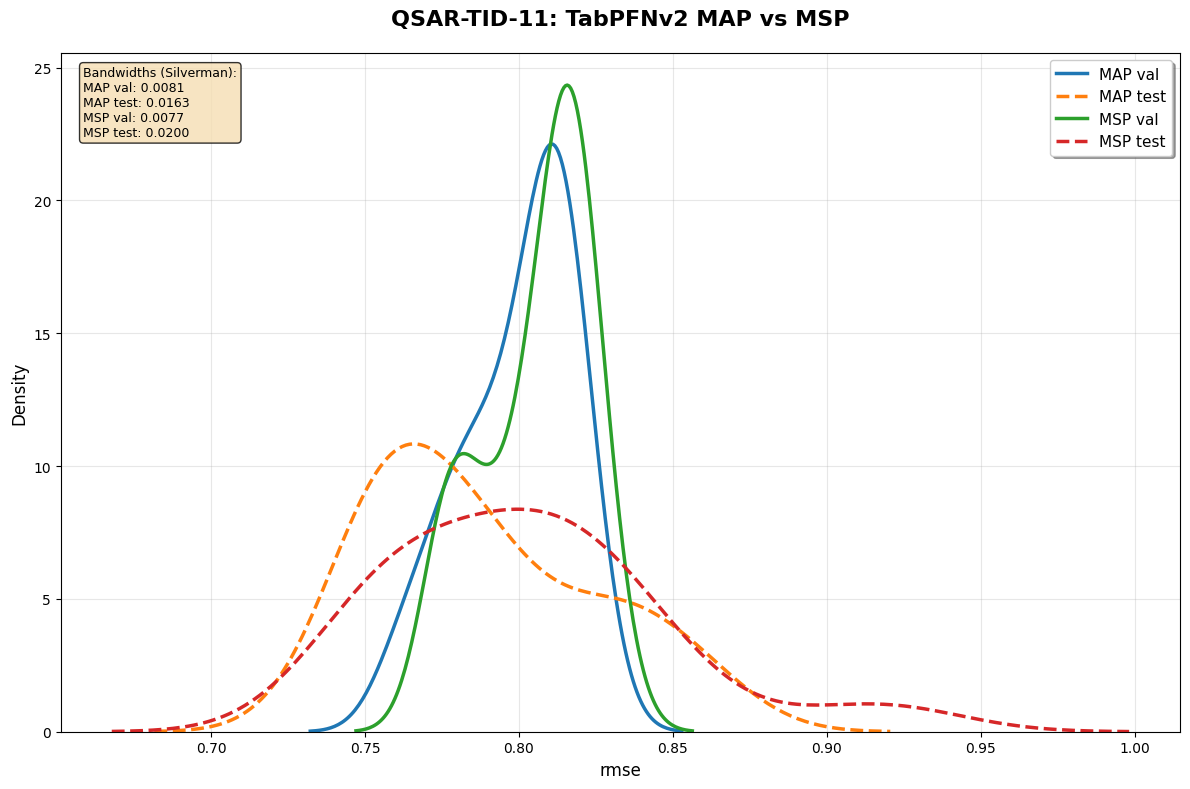


                    STATISTICAL ANALYSIS

SUMMARY STATISTICS:
--------------------------------------------------------------------------------
Distribution         Mean       Std        Median     Min        Max       
--------------------------------------------------------------------------------
MAP val              0.799825   0.017708   0.805240   0.760723   0.824408  
MAP test             0.788515   0.035756   0.783566   0.739136   0.863074  
MSP val              0.805697   0.016881   0.812894   0.774238   0.829144  
MSP test             0.802686   0.044186   0.795610   0.738861   0.927087  

STATISTICAL TESTS:
--------------------------------------------------------------------------------

1. VALIDATION PERFORMANCE COMPARISON:
   Mann-Whitney U statistic: 349.0000
   p-value: 0.137323
   Result: No significant difference (α = 0.05)

2. TEST PERFORMANCE COMPARISON:
   Mann-Whitney U statistic: 371.0000
   p-value: 0.245814
   Result: No significant difference (α = 0.05)

3. EFFE

In [4]:
model_agnostic_path = '/work/dlclarge2/matusd-toy_example/experiments/results/tabarena_map/gpu_complete/qsar_tid_11/tabpfnv2_tab/pca_dr/results.csv'
model_specific_path = '/work/dlclarge2/matusd-toy_example/experiments/results/tabarena_msp/complete/qsar_tid_11/tabpfnv2_tab/pca_dr/results.csv'
output_dir = '/work/dlclarge2/matusd-toy_example/experiments/results/figures/val_vs_test_distributions'

os.makedirs(output_dir, exist_ok=True)

# Create analyzer instance
analyzer = PreprocessingComparison(
    model_agnostic_path=model_agnostic_path,
    model_specific_path=model_specific_path,
    output_dir=output_dir,
    filename="qsar_tid_11_tabpfnv2_map_msp",
    title="QSAR-TID-11: TabPFNv2 MAP vs MSP",
    val_col='val_rmse',
    test_col='rmse',
    metric_name='rmse',
    lower_is_better=True
)

# Run full analysis
results = analyzer.run_full_analysis()

                    LOADING DATA

✅ Data loaded successfully!
Model-Agnostic: 30 validation, 30 test samples
Model-Specific: 30 validation, 30 test samples
Output directory: /work/dlclarge2/matusd-toy_example/experiments/results/figures/val_vs_test_distributions

        PREPROCESSING COMPARISON ANALYSIS
Timestamp: 2025-10-01 15:12:47

CREATING MAIN COMPARISON PLOT

Calculated Bandwidths (Silverman's rule):
  MAP val: 0.002045
  MAP test: 0.003709
  MSP val: 0.002435
  MSP test: 0.002941
✅ Saved: /work/dlclarge2/matusd-toy_example/experiments/results/figures/val_vs_test_distributions/bioresponse_tabpfnv2_map_msp_kde_comparison_main.png


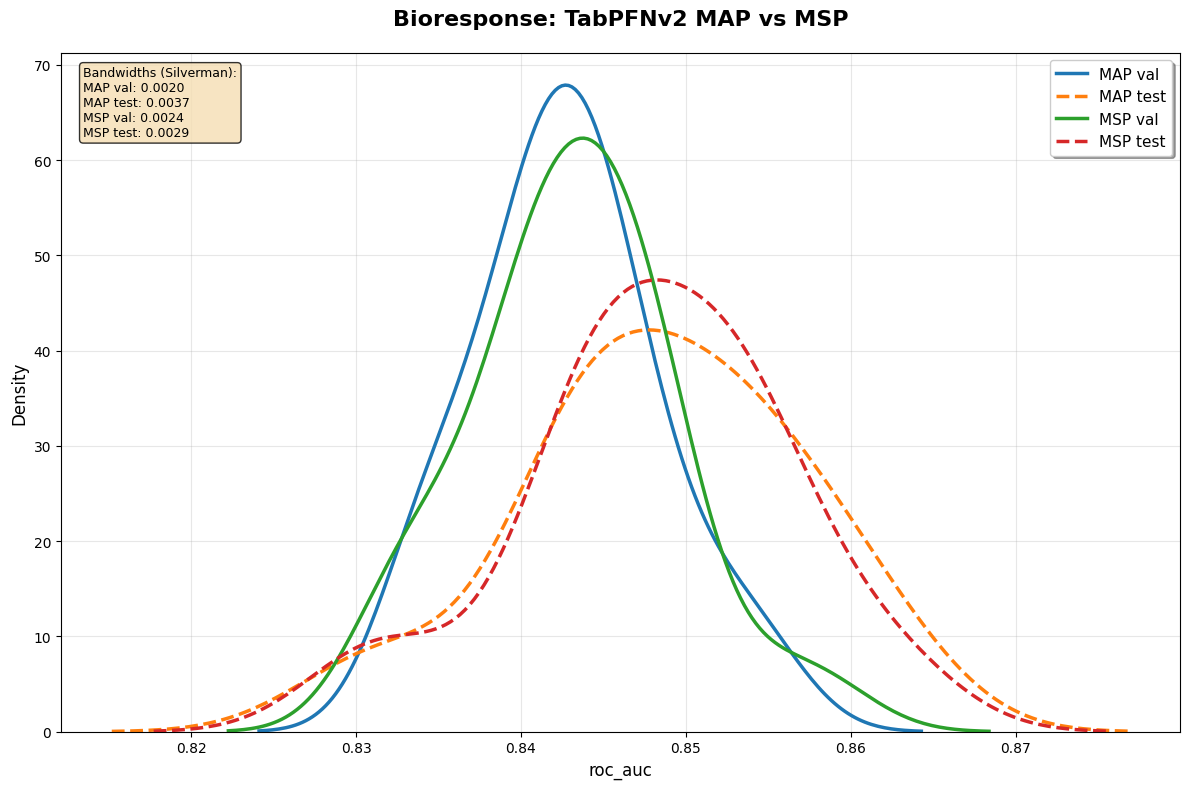


                    STATISTICAL ANALYSIS

SUMMARY STATISTICS:
--------------------------------------------------------------------------------
Distribution         Mean       Std        Median     Min        Max       
--------------------------------------------------------------------------------
MAP val              0.842771   0.005531   0.842811   0.833014   0.855382  
MAP test             0.848441   0.008487   0.848901   0.828839   0.863228  
MSP val              0.843180   0.006124   0.843843   0.832109   0.858533  
MSP test             0.848118   0.007962   0.848211   0.830533   0.862689  

STATISTICAL TESTS:
--------------------------------------------------------------------------------

1. VALIDATION PERFORMANCE COMPARISON:
   Mann-Whitney U statistic: 423.0000
   p-value: 0.695215
   Result: No significant difference (α = 0.05)

2. TEST PERFORMANCE COMPARISON:
   Mann-Whitney U statistic: 458.0000
   p-value: 0.911709
   Result: No significant difference (α = 0.05)

3. EFFE

In [5]:
model_agnostic_path = '/work/dlclarge2/matusd-toy_example/experiments/results/tabarena_map/gpu_complete/bioresponse/tabpfnv2_tab/pca_dr/results.csv'
model_specific_path = '/work/dlclarge2/matusd-toy_example/experiments/results/tabarena_msp/complete/bioresponse/tabpfnv2_tab/pca_dr/results.csv'
output_dir = '/work/dlclarge2/matusd-toy_example/experiments/results/figures/val_vs_test_distributions'

os.makedirs(output_dir, exist_ok=True)

# Create analyzer instance
analyzer = PreprocessingComparison(
    model_agnostic_path=model_agnostic_path,
    model_specific_path=model_specific_path,
    output_dir=output_dir,
    filename="bioresponse_tabpfnv2_map_msp",
    title="Bioresponse: TabPFNv2 MAP vs MSP",
    val_col='val_roc_auc',
    test_col='roc_auc',
    metric_name='roc_auc',
    lower_is_better=True
)

# Run full analysis
results = analyzer.run_full_analysis()

                    LOADING DATA

✅ Data loaded successfully!
Model-Agnostic: 30 validation, 30 test samples
Model-Specific: 30 validation, 30 test samples
Output directory: /work/dlclarge2/matusd-toy_example/experiments/results/figures/val_vs_test_distributions

        PREPROCESSING COMPARISON ANALYSIS
Timestamp: 2025-10-01 15:12:48

CREATING MAIN COMPARISON PLOT

Calculated Bandwidths (Silverman's rule):
  MAP val: 0.000479
  MAP test: 0.000550
  MSP val: 0.000378
  MSP test: 0.000604
✅ Saved: /work/dlclarge2/matusd-toy_example/experiments/results/figures/val_vs_test_distributions/hiva_agnostic_tabpfnv2_map_msp_kde_comparison_main.png


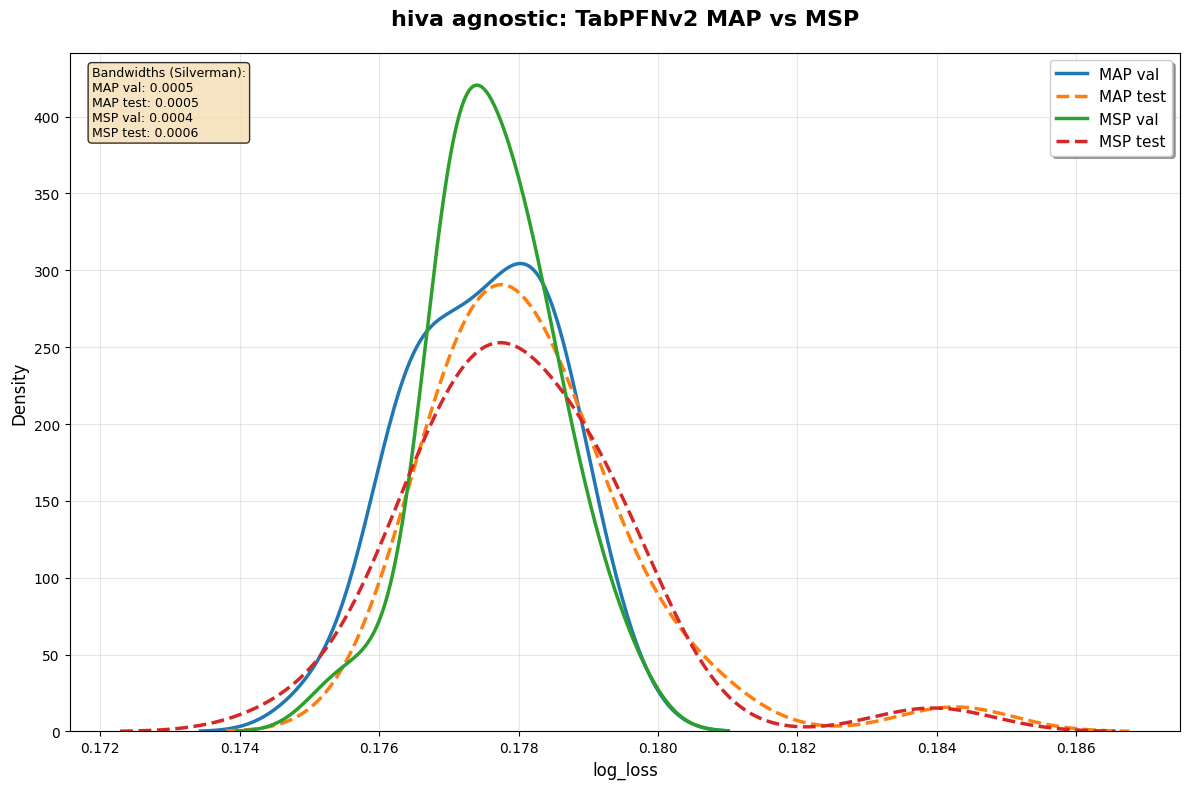


                    STATISTICAL ANALYSIS

SUMMARY STATISTICS:
--------------------------------------------------------------------------------
Distribution         Mean       Std        Median     Min        Max       
--------------------------------------------------------------------------------
MAP val              0.177492   0.001052   0.177487   0.175130   0.179301  
MAP test             0.178228   0.001555   0.177921   0.176302   0.184262  
MSP val              0.177634   0.000890   0.177610   0.175397   0.179578  
MSP test             0.178037   0.001628   0.177762   0.174905   0.183947  

STATISTICAL TESTS:
--------------------------------------------------------------------------------

1. VALIDATION PERFORMANCE COMPARISON:
   Mann-Whitney U statistic: 418.0000
   p-value: 0.641424
   Result: No significant difference (α = 0.05)

2. TEST PERFORMANCE COMPARISON:
   Mann-Whitney U statistic: 467.0000
   p-value: 0.807275
   Result: No significant difference (α = 0.05)

3. EFFE

In [6]:
model_agnostic_path = '/work/dlclarge2/matusd-toy_example/experiments/results/tabarena_map/gpu_complete/hiva_agnostic/tabpfnv2_tab/pca_dr/results.csv'
model_specific_path = '/work/dlclarge2/matusd-toy_example/experiments/results/tabarena_msp/complete/hiva_agnostic/tabpfnv2_tab/pca_dr/results.csv'
output_dir = '/work/dlclarge2/matusd-toy_example/experiments/results/figures/val_vs_test_distributions'

os.makedirs(output_dir, exist_ok=True)

# Create analyzer instance
analyzer = PreprocessingComparison(
    model_agnostic_path=model_agnostic_path,
    model_specific_path=model_specific_path,
    output_dir=output_dir,
    filename="hiva_agnostic_tabpfnv2_map_msp",
    title="hiva agnostic: TabPFNv2 MAP vs MSP",
    val_col='val_log_loss',
    test_col='log_loss',
    metric_name='log_loss',
    lower_is_better=True
)

# Run full analysis
results = analyzer.run_full_analysis()